# PSYCH 239: Week 5: Training your own Resnet


In [0]:
import torch
from torchvision import datasets, transforms
import torchvision
import tqdm

In [0]:
preprocess = transforms.Compose([
       transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [3]:
train_set = datasets.CIFAR10('./data',
                           train=True, download=True,
                           transform=preprocess,
                           target_transform = None,)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
test_set = datasets.CIFAR10('./data',
                           train=False, download=True,
                           transform=preprocess,
                           target_transform = None,)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=True)

Files already downloaded and verified


In [0]:
net10 = torchvision.models.resnet18(pretrained=False, progress=True, num_classes=10).cuda()

In [0]:
mse_loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net10.parameters(), lr=1e-3)

In [0]:
def train_step(x, t, net, opt_fn, loss_fn):
    y = net(x.cuda())
    loss = loss_fn(y, t.cuda())
    loss.backward()
    opt_fn.step()
    opt_fn.zero_grad()
    return loss

In [8]:
x,t = next(iter(train_loader))
train_step(x, t, net10, opt, mse_loss)

tensor(2.2589, device='cuda:0', grad_fn=<NllLossBackward>)

Train the network over multiple epochs

In [9]:
acc_hist_train = []
acc_hist_test = []
for epoch in range(5):
    acc_batch = []
    net.train()
    for x,t in tqdm.tqdm(iter(train_loader)):   
        loss_train = train_step(x, t, net10, opt, mse_loss)
        y = net10(x.cuda()).cpu()
        acc_batch.append(torch.mean((t == y.argmax(1)).float()))
    acc_hist_train.append(torch.mean(torch.FloatTensor(acc_batch)))   
    print(loss_train)

    acc_batch = []
    net.eval()
    for x,t in iter(test_loader):   
        y = net10(x.cuda()).cpu()
        acc_batch.append(torch.mean((t == y.argmax(1)).float()))
    acc_hist_test.append(torch.mean(torch.FloatTensor(acc_batch)))  
    print(acc_hist_test[-1]) 

100%|██████████| 500/500 [04:57<00:00,  1.68it/s]


tensor(0.9269, device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/500 [00:00<?, ?it/s]

tensor(0.6416)


100%|██████████| 500/500 [04:56<00:00,  1.67it/s]


tensor(0.7116, device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/500 [00:00<?, ?it/s]

tensor(0.7438)


100%|██████████| 500/500 [04:56<00:00,  1.66it/s]


tensor(0.6581, device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/500 [00:00<?, ?it/s]

tensor(0.7932)


100%|██████████| 500/500 [04:56<00:00,  1.68it/s]


tensor(0.4213, device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/500 [00:00<?, ?it/s]

tensor(0.8118)


100%|██████████| 500/500 [04:56<00:00,  1.68it/s]


tensor(0.3671, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8138)


In [10]:
acc_hist_test

[tensor(0.6416),
 tensor(0.7438),
 tensor(0.7932),
 tensor(0.8118),
 tensor(0.8138)]

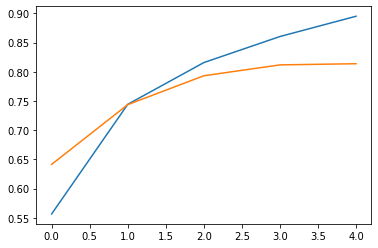

In [11]:
import pylab as plt
plt.plot(range(len(acc_hist_train)), acc_hist_train)
plt.plot(range(len(acc_hist_test)), acc_hist_test)

In [0]:
from torchvision.models.resnet import ResNet, BasicBlock, conv1x1,conv3x3
from torch import nn

In [0]:
class ResNet(nn.Module):

    def __init__(self, block=BasicBlock, layers=[2, 2, 2, 2], num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [0]:
net10_1 = ResNet()

In [15]:
train_set = datasets.FashionMNIST('./data',
                           train=True, download=True,
                           transform = transforms.Compose([
       transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize(mean=[ 0.406], std=[0.225])
    ]),
                           target_transform = None,)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [0]:
data,target = next(iter(train_loader))

In [17]:
data.shape

torch.Size([100, 1, 224, 224])

In [18]:
net10_1(data)

tensor([[-0.3737,  0.0335, -0.0230,  ...,  0.5466,  0.0158, -0.9470],
        [-0.4654,  0.3327,  0.2856,  ...,  0.2002,  0.0450, -0.8982],
        [-0.6445,  0.1819,  0.1882,  ...,  0.2281, -0.0104, -1.0847],
        ...,
        [-0.5502,  0.4076,  0.3003,  ...,  0.2613,  0.3268, -1.0812],
        [-0.3990,  0.0522,  0.1797,  ...,  0.3739,  0.0645, -0.9647],
        [-0.4493,  0.1997, -0.0895,  ...,  0.4236,  0.0899, -0.9495]],
       grad_fn=<AddmmBackward>)